# Most Valuable Customers
 
 ## Background
 The (hypothetical) company in which I work as a senior data analyst, Summit Outfitters, has recently secured a substantial round of investment to expand its market presence both online and in flagship stores located in prime outdoor destinations. Summit Outfitters is known for its premium gear catering to outdoor enthusiasts, including climbers, hikers, skiers, and trail runners. 
 
 The company has maintained steady growth through a loyal customer base and strong brand reputation after being acquired by an investment group. Now, under the strategic guidance of our new visionary CEO, Alex Rivera, Summit Outfitters is ready to leverage its current momentum and tap into broader markets. Alex believes that a deep understanding of the company's current customer base will allow us to refine our marketing efforts, enhance product offerings, and increase sales efficiency, leading us to new heights of success. 

 Alex Rivera approached me with a strategic request from the recent investment round. The investors are interested in maximizing returns by enhancing the efficiency of marketing spend and increasing the average customer lifetime value. They want to focus on two key areas:
 - Identifying the most valuable customers from the existing customer base. What makes these customers valuable? The goal is to understand what makes these customers valuable, whether it's through their purchasing patterns, loyalty, or average transaction value. This understanding will help in tailoring marketing campaigns and loyalty programs that effectively target and retain these segments.
 - Exploring cross-selling and up-selling opportunities. With a diverse range of products, from technical climbing gear to premium outdoor apparel, Alex believes there is untapped potential in cross-selling and upselling. He wants you to use the customer transaction data to identify opportunities where customers purchasing certain items might be interested in others. For example, customers buying high-end skis might be potential targets for premium ski wear or exclusive ski accessories.

Alex expects a comprehensive report that not only identifies key customer segments and outlines potential cross-sell and upsell strategies but also provides actionable insights and practical recommendations for targeted marketing initiatives. The focus is on enhancing customer experience and maximizing revenue per customer, and my expertise will play a significant part in achieving these goals.

## Approach
To address Alex Rivera's strategic request, I will follow a structured approach that involves the following key steps:
1. Understand the problem, including the definitions of individual words/concepts.
2. Determine a minimum viable answer that we can use to make a decision and prompt further questions.
3. Identify any additional information that would be helpful (data, people, etc.) to have to get the minimum viable answer.
4. Obtain the data. 
5. Plan and execute the work required to get the minimum viable answer.
6. Review the results and determine if we need to do more work.
7. Iterate as needed.

### Understand
- **Most Valuable Customers**: These are customers who contribute significantly to the company's revenue and profitability. They may exhibit high purchase frequency, high average transaction value, or long-term loyalty.
- **Cross-Selling**: This involves selling additional products or services to an existing customer. The goal is to increase the customer's value by offering complementary or related items.
- **Up-Selling**: This involves persuading a customer to buy a more expensive version of a product or to add features or upgrades. The goal is to increase the customer's spending per transaction.

### Minimum Viable Answers
1. Who are our most valuable customers?
2. In which customer segments can we leverage cross-selling and up-selling opportunities?

### Data
*This data comes from the publicly-avaiable [Online Retail Customer Churn Dataset](https://www.kaggle.com/datasets/hassaneskikri/online-retail-customer-churn-dataset) on Kaggle. For the sake of this case study, let's pretend that it came from our company's data lake.*

I ran the following query on our company's data lake to pull the relevant data:
```sql
with customer_bio as (
        select Customer_ID
        , Age
        , Gender
        , Annual_Income 
        from customers c)
    , customer_activity as (
        select sum(Purchase_Amt) over (partition by Customer_ID) as Total_Spend
        , date_diff(max(date(Timestamp)), min(date(Timestamp)), year) as Years_as_Customer
        , count(*) over (partition by Customer_ID) as Num_of_Purchases
        , avg(purchase_amt) over (partition by Customer_ID) as Average_Transaction_Amount
        , sum(Return_Amt) over (partition by Customer_ID) as Num_of_Returns
        , date_diff(current_date(), max(date(Timestamp)) over (partition by Customer_ID), day) as Last_Purchase_Days_Ago 
        from purchases p)
select cb.Customer_ID
    , cb.Age
    , cb.Gender
    , cb.Annual_Income
    , ca.Total_Spend
    , ca.Years_as_Customer
    , ca.Num_of_Purchases
    , ca.Average_Transaction_Amount
    , ca.Num_of_Returns
    , ca.Last_Purchase_Days_Ago
from customer_bio cb join customer_activity ca on cb.Customer_ID = ca.Customer_ID
limit 1000;
```
to get the following columns: 
- Customer_ID
- Age
- Gender
- Annual_Income
- Total_Spend
- Years_as_Customer
- Num_of_Purchases
- Average_Transaction_Amount
- Num_of_Returns
- Last_Purchase_Days_Ago

### Do the Work

In [1]:
import pandas as pd
df = pd.read_csv("../data/online_retail_customer_churn.csv", 
                 usecols=["Customer_ID", "Age", "Gender", "Annual_Income", "Total_Spend", "Years_as_Customer", 
                          "Num_of_Purchases", "Average_Transaction_Amount", "Num_of_Returns", "Last_Purchase_Days_Ago"],
                 index_col="Customer_ID")

In [2]:
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                              
1             62  Other          45.15      5892.58                  5   
2             65   Male          79.51      9025.47                 13   
3             18   Male          29.19       618.83                 13   
4             21  Other          79.63      9110.30                  3   
5             21  Other          77.66      5390.88                 15   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                          22                      453.80               2   
2                          77                       22.90               2   
3                          71                       50.53               5   
4                          33                      411.83               5   
5                          43                      101.19               3   

             Last_Purchase_Days_Ago  
Customer_ID                          
1                               129  
2                               227  
3                               283  
4                               226  
5                               242

In [3]:
# Let's check whether there are any missing values in the dataset
df.isnull().sum()

Age                           0
Gender                        0
Annual_Income                 0
Total_Spend                   0
Years_as_Customer             0
Num_of_Purchases              0
Average_Transaction_Amount    0
Num_of_Returns                0
Last_Purchase_Days_Ago        0
dtype: int64

In [4]:
# Let me step out of this case study for a moment. I have rarely seen a dataset with no missing values. Let's make this more realistic.
import numpy as np

# Determine the number of values to replace with missing values: 1.5% of the dataset
n_missing = int(df.size * 0.025)

# Create a Boolean mask of the same shape as the dataframe, with n_missing elements set to True
np.random.seed(42)
mask = np.random.choice([True, False], size=df.shape, p=[0.015, 0.985])

# Apply the mask to the dataframe
df[mask] = np.nan

#### Cleaning and Exploring the Data
Let's start by exploring the data's structure and contents. Let's check for missing values, outliers and any other data quality issues that need to be addressed.

In [5]:
# Check import dtypes and convert them to the best possible dtypes. This is a small dataset, but it's a good practice to do this anyway.
print(f"Old dtypes:\n{df.dtypes}")
df = df.convert_dtypes()
print(f"New dtypes:\n{df.dtypes}")

Old dtypes:
Age                           float64
Gender                         object
Annual_Income                 float64
Total_Spend                   float64
Years_as_Customer             float64
Num_of_Purchases              float64
Average_Transaction_Amount    float64
Num_of_Returns                float64
Last_Purchase_Days_Ago        float64
dtype: object
New dtypes:
Age                                    Int64
Gender                        string[python]
Annual_Income                        Float64
Total_Spend                          Float64
Years_as_Customer                      Int64
Num_of_Purchases                       Int64
Average_Transaction_Amount           Float64
Num_of_Returns                         Int64
Last_Purchase_Days_Ago                 Int64
dtype: object


In [6]:
df.info()
print(f"\nThe DataFrame is {df.shape[0]} samples long.")

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         985 non-null    Int64  
 1   Gender                      980 non-null    string 
 2   Annual_Income               982 non-null    Float64
 3   Total_Spend                 988 non-null    Float64
 4   Years_as_Customer           985 non-null    Int64  
 5   Num_of_Purchases            984 non-null    Int64  
 6   Average_Transaction_Amount  991 non-null    Float64
 7   Num_of_Returns              986 non-null    Int64  
 8   Last_Purchase_Days_Ago      984 non-null    Int64  
dtypes: Float64(3), Int64(5), string(1)
memory usage: 85.9 KB

The DataFrame is 1000 samples long.


In [7]:
df.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count       985.0     980          982.0        988.0              985.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     338           <NA>         <NA>               <NA>   
mean    43.372589     NaN     112.336334  5075.046579           9.724873   
std      15.24416     NaN      52.859585  2867.032929           5.530628   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN         68.105      2674.28                5.0   
50%          44.0     NaN        115.135      4961.63                9.0   
75%          56.0     NaN        158.535      7606.47               14.0   
max          69.0     NaN         199.73      9999.64               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count              984.0                       991.0           986.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean                49.5                  266.888365        4.606491   
std             28.54808                  146.091766        2.900257   
min                  1.0                       10.46             0.0   
25%                 25.0                     139.475             2.0   
50%                 49.0                      270.56             5.0   
75%                 74.0                     401.745             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                    984.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                183.388211  
std                  104.45929  
min                        1.0  
25%                       93.0  
50%                      181.0  
75%                      274.0  
max                      364.0

In [8]:
# What immediately pops out are the three unique genders. Let's see how those are categorized.
df["Gender"].value_counts()

Gender
Female    338
Male      325
Other     317
Name: count, dtype: Int64

The `Gender`s look valid and evenly-distributed, so we don't need to do sophisticated imputation on that variable.

Looking at the numeric columns, the mean and standard deviation of each column looks very close to the corresponding median and 75th percentile. This gestures towards normality, but the min and max values around around two standard deviations from the mean, so visualizing the distributions will be helpful.

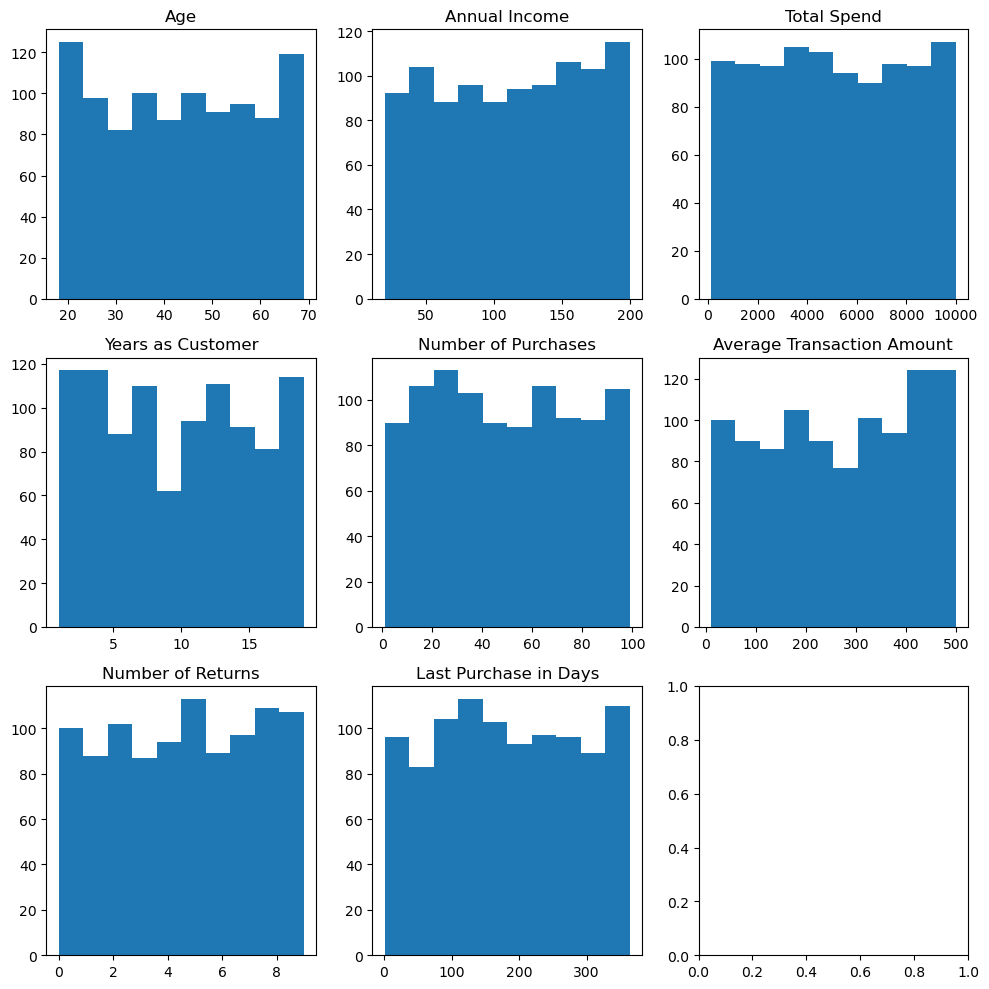

In [9]:
# Let's plot histograms of the numeric columns.
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes[0, 0].hist(df["Age"])
axes[0, 0].set_title("Age")

axes[0, 1].hist(df["Annual_Income"])
axes[0, 1].set_title("Annual Income")

axes[0, 2].hist(df["Total_Spend"])
axes[0, 2].set_title("Total Spend")

axes[1, 0].hist(df["Years_as_Customer"])
axes[1, 0].set_title("Years as Customer")

axes[1, 1].hist(df["Num_of_Purchases"])
axes[1, 1].set_title("Number of Purchases")

axes[1, 2].hist(df["Average_Transaction_Amount"])
axes[1, 2].set_title("Average Transaction Amount")

axes[2, 0].hist(df["Num_of_Returns"])
axes[2, 0].set_title("Number of Returns")

axes[2, 1].hist(df["Last_Purchase_Days_Ago"])
axes[2, 1].set_title("Last Purchase in Days")

plt.tight_layout()
plt.show()

They're all skewed, so we will need to think about our imputation method. We have several options:
- Mean: This is probably not the best choice, as the distributions are skewed. It's trivial to impute and compare the results to the original dataset's summary statistics, but I'm not sure it will be the most accurate.
- Median: This is a better choice for skewed distributions, but it's not perfect. It's also trivial to impute and compare the results to the original dataset's summary statistics.
- Mode: If the datasets exhibited any peakedness, this may be a good choice. In this case, however, it's not appropriate.
- K-means/Multivariate: This is the most sophisticated method, but it's also the most accurate. It's not trivial to implement, but it can be worth the effort.

My instinct is to use the median, as it's the most appropriate for skewed distributions and it's trivial to implement. I'll compare the results of mean and median imputation to the original dataset's summary statistics to see which is the better choice. K-means imputation is attractive, but there are three reasons I'm not going to use it unless absolutely necessary:
1. The number of missing points is extremely low, so inaccurate values should not significantly affect the overall distribution. 
2. This analysis is coming on the heels of a recent investing round. It would be better to get a quick answer and iterate than to spend a lot of time on a sophisticated method that may not be necessary. I would rather spend more time analyzing the results and iterating on the analysis than overinvesting in the imputation method.
3. We will be looking at clusters, so our precision in imputation is less important than it would be in a regression or classification problem.

First, let's fill the `Gender` column, then we'll impute the missing values in the numeric columns.

In [10]:
num_missing = df["Gender"].isnull().sum()
imputed_genders = np.random.choice(["Female", "Male", "Other"], size=num_missing, p=[0.33, 0.33, 0.34])
df.loc[df['Gender'].isnull(), 'Gender'] = imputed_genders

print(df["Gender"].value_counts())
print(f"\n{df["Gender"].isnull().sum()} missing values remain.")

Gender
Female    346
Male      334
Other     320
Name: count, dtype: Int64

0 missing values remain.


In [11]:
# Let's return to the numeric columns and compare mean vs. median imputation.
import pandas as pd
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()


def mean_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    for column in column_list:
        mean_value = df[column].mean()
        if pd.api.types.is_integer_dtype(df[column].dtype):
            mean_value = round(mean_value)
        df[column] = df[column].fillna(mean_value)
    return df

def median_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    for column in column_list:
        median_value = df[column].median()
        if pd.api.types.is_integer_dtype(df[column].dtype):
            median_value = round(median_value)
        df[column] = df[column].fillna(median_value)
    return df

df_mean = mean_imputation(df.copy(), numeric_columns)
df_median = median_imputation(df.copy(), numeric_columns)

In [12]:
# Original dataset
df.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count       985.0    1000          982.0        988.0              985.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     346           <NA>         <NA>               <NA>   
mean    43.372589     NaN     112.336334  5075.046579           9.724873   
std      15.24416     NaN      52.859585  2867.032929           5.530628   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN         68.105      2674.28                5.0   
50%          44.0     NaN        115.135      4961.63                9.0   
75%          56.0     NaN        158.535      7606.47               14.0   
max          69.0     NaN         199.73      9999.64               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count              984.0                       991.0           986.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean                49.5                  266.888365        4.606491   
std             28.54808                  146.091766        2.900257   
min                  1.0                       10.46             0.0   
25%                 25.0                     139.475             2.0   
50%                 49.0                      270.56             5.0   
75%                 74.0                     401.745             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                    984.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                183.388211  
std                  104.45929  
min                        1.0  
25%                       93.0  
50%                      181.0  
75%                      274.0  
max                      364.0

In [13]:
# Mean-imputed dataset
df_mean.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count      1000.0    1000         1000.0       1000.0             1000.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     346           <NA>         <NA>               <NA>   
mean       43.367     NaN     112.336334  5075.046579              9.729   
std     15.129349     NaN      52.381208  2849.761489           5.489052   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN        68.8025      2685.34                5.0   
50%          43.0     NaN        113.315      5030.21               10.0   
75%          56.0     NaN       158.4125     7593.375               14.0   
max          69.0     NaN         199.73      9999.64               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count             1000.0                      1000.0          1000.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean              49.508                  266.888365           4.612   
std            28.318614                  145.432206        2.880235   
min                  1.0                       10.46             0.0   
25%                 25.0                     140.565             2.0   
50%                 49.0                     267.755             5.0   
75%                 74.0                    400.2675             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                   1000.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                   183.382  
std                 103.619414  
min                        1.0  
25%                       94.0  
50%                      183.0  
75%                      273.0  
max                      364.0

In [14]:
# Median-imputed dataset
df_median.describe(include="all")

Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
count      1000.0    1000         1000.0       1000.0             1000.0   
unique       <NA>       3           <NA>         <NA>               <NA>   
top          <NA>  Female           <NA>         <NA>               <NA>   
freq         <NA>     346           <NA>         <NA>               <NA>   
mean       43.382     NaN      112.38671   5073.68558              9.714   
std     15.129474     NaN      52.382531  2849.788273           5.489658   
min          18.0     NaN          20.01       108.94                1.0   
25%          30.0     NaN        68.8025      2685.34                5.0   
50%          44.0     NaN        115.135      4961.63                9.0   
75%          56.0     NaN       158.4125     7593.375               14.0   
max          69.0     NaN         199.73      9999.64               19.0   

        Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
count             1000.0                      1000.0          1000.0   
unique              <NA>                        <NA>            <NA>   
top                 <NA>                        <NA>            <NA>   
freq                <NA>                        <NA>            <NA>   
mean              49.492                   266.92141           4.612   
std            28.318614                   145.43262        2.880235   
min                  1.0                       10.46             0.0   
25%                 25.0                     140.565             2.0   
50%                 49.0                      270.56             5.0   
75%                 74.0                    400.2675             7.0   
max                 99.0                      499.57             9.0   

        Last_Purchase_Days_Ago  
count                   1000.0  
unique                    <NA>  
top                       <NA>  
freq                      <NA>  
mean                    183.35  
std                 103.619837  
min                        1.0  
25%                       94.0  
50%                      181.0  
75%                      273.0  
max                      364.0

In [15]:
# Ultimately, they're not that different. Let's go with median imputation since the datasets are skewed.
df = df_median

In [16]:
# Let's check for outlier values, which we'll define as values with a Z-score higher than 2.
from scipy import stats

def zscore_outliers(df, column_list=None, zscore_threshold=2):
    if column_list is None:
        column_list = df.select_dtypes(include=['number']).columns.tolist()

    zscores = df[column_list].apply(stats.zscore)
    return df[(zscores.abs() > zscore_threshold).any(axis=1)]

outliers = zscore_outliers(df, zscore_threshold=2)
print(f"{outliers.shape[0]} outliers found.")

0 outliers found.


#### Correlation and Feature Engineering
I have some ideas for metrics that could be useful in identifying the most valuable customers, such as Customer Value Index and purchase frequency analysis. Let's look at feature correlation and see whether there are other metrics that could be useful in identifying the most valuable customers.

In [17]:
df.head()

Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                              
1             62  Other          45.15      5892.58                  5   
2             65   Male          79.51      9025.47                 13   
3             18   Male          29.19       618.83                 13   
4             21  Other          79.63       9110.3                  3   
5             21  Other          77.66      5390.88                 15   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                          22                       453.8               2   
2                          77                        22.9               2   
3                          71                       50.53               5   
4                          33                      411.83               5   
5                          43                      101.19               3   

             Last_Purchase_Days_Ago  
Customer_ID                          
1                               129  
2                               227  
3                               283  
4                               226  
5                               242

In [18]:
# Calculate a new feature: Spend per Year
df["Spend_Per_Year"] = df["Total_Spend"] / df["Years_as_Customer"]

In [19]:
# Calculate a new feature: Purchase Frequency
df["Purchase_Frequency"] = df["Num_of_Purchases"] / df["Years_as_Customer"]

In [20]:
# Calculate a new feature: Return Rate
df["Return_Rate"] = df["Num_of_Returns"] / df["Num_of_Purchases"]

In [21]:
#Calculate a new feature: Spend Frequency Ratio
df["Spend_Frequency_Ratio"] = df["Total_Spend"] / df["Num_of_Purchases"]

In [22]:
# The numeric columns are on different scales. Let's standardize them using StandardScaler.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = df.copy().drop(columns=["Gender"])
scaled_data = scaler.fit_transform(scaled_df.values)

In [23]:
scaled_df = pd.DataFrame(
    scaled_data, index=scaled_df.index, columns=scaled_df.columns)

In [24]:
scaled_df.head()

Age  Annual_Income  Total_Spend  Years_as_Customer  \
Customer_ID                                                            
1            1.231194      -1.284214     0.287497          -0.859135   
2            1.429582      -0.627941     1.387388           0.598880   
3           -1.678492      -1.589048    -1.564006           0.598880   
4           -1.480104      -0.625649     1.417170          -1.223639   
5           -1.480104      -0.663276     0.111360           0.963383   

             Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
Customer_ID                                                                 
1                   -0.971296                    1.285627       -0.907324   
2                    0.971861                   -1.678740       -0.907324   
3                    0.759880                   -1.488660        0.134779   
4                   -0.582665                    0.996895        0.134779   
5                   -0.229363                   -1.140145       -0.559957   

             Last_Purchase_Days_Ago  Spend_Per_Year  Purchase_Frequency  \
Customer_ID                                                               
1                         -0.524776        0.142120           -0.373034   
2                          0.421462       -0.193790           -0.269951   
3                          0.962170       -0.642362           -0.301189   
4                          0.411807        1.431133            0.073659   
5                          0.566295       -0.426082           -0.476812   

             Return_Rate  Spend_Frequency_Ratio  
Customer_ID                                      
1              -0.244655              -0.001620  
2              -0.353484              -0.191697  
3              -0.278990              -0.328608  
4              -0.143081               0.008759  
5              -0.280088              -0.181406

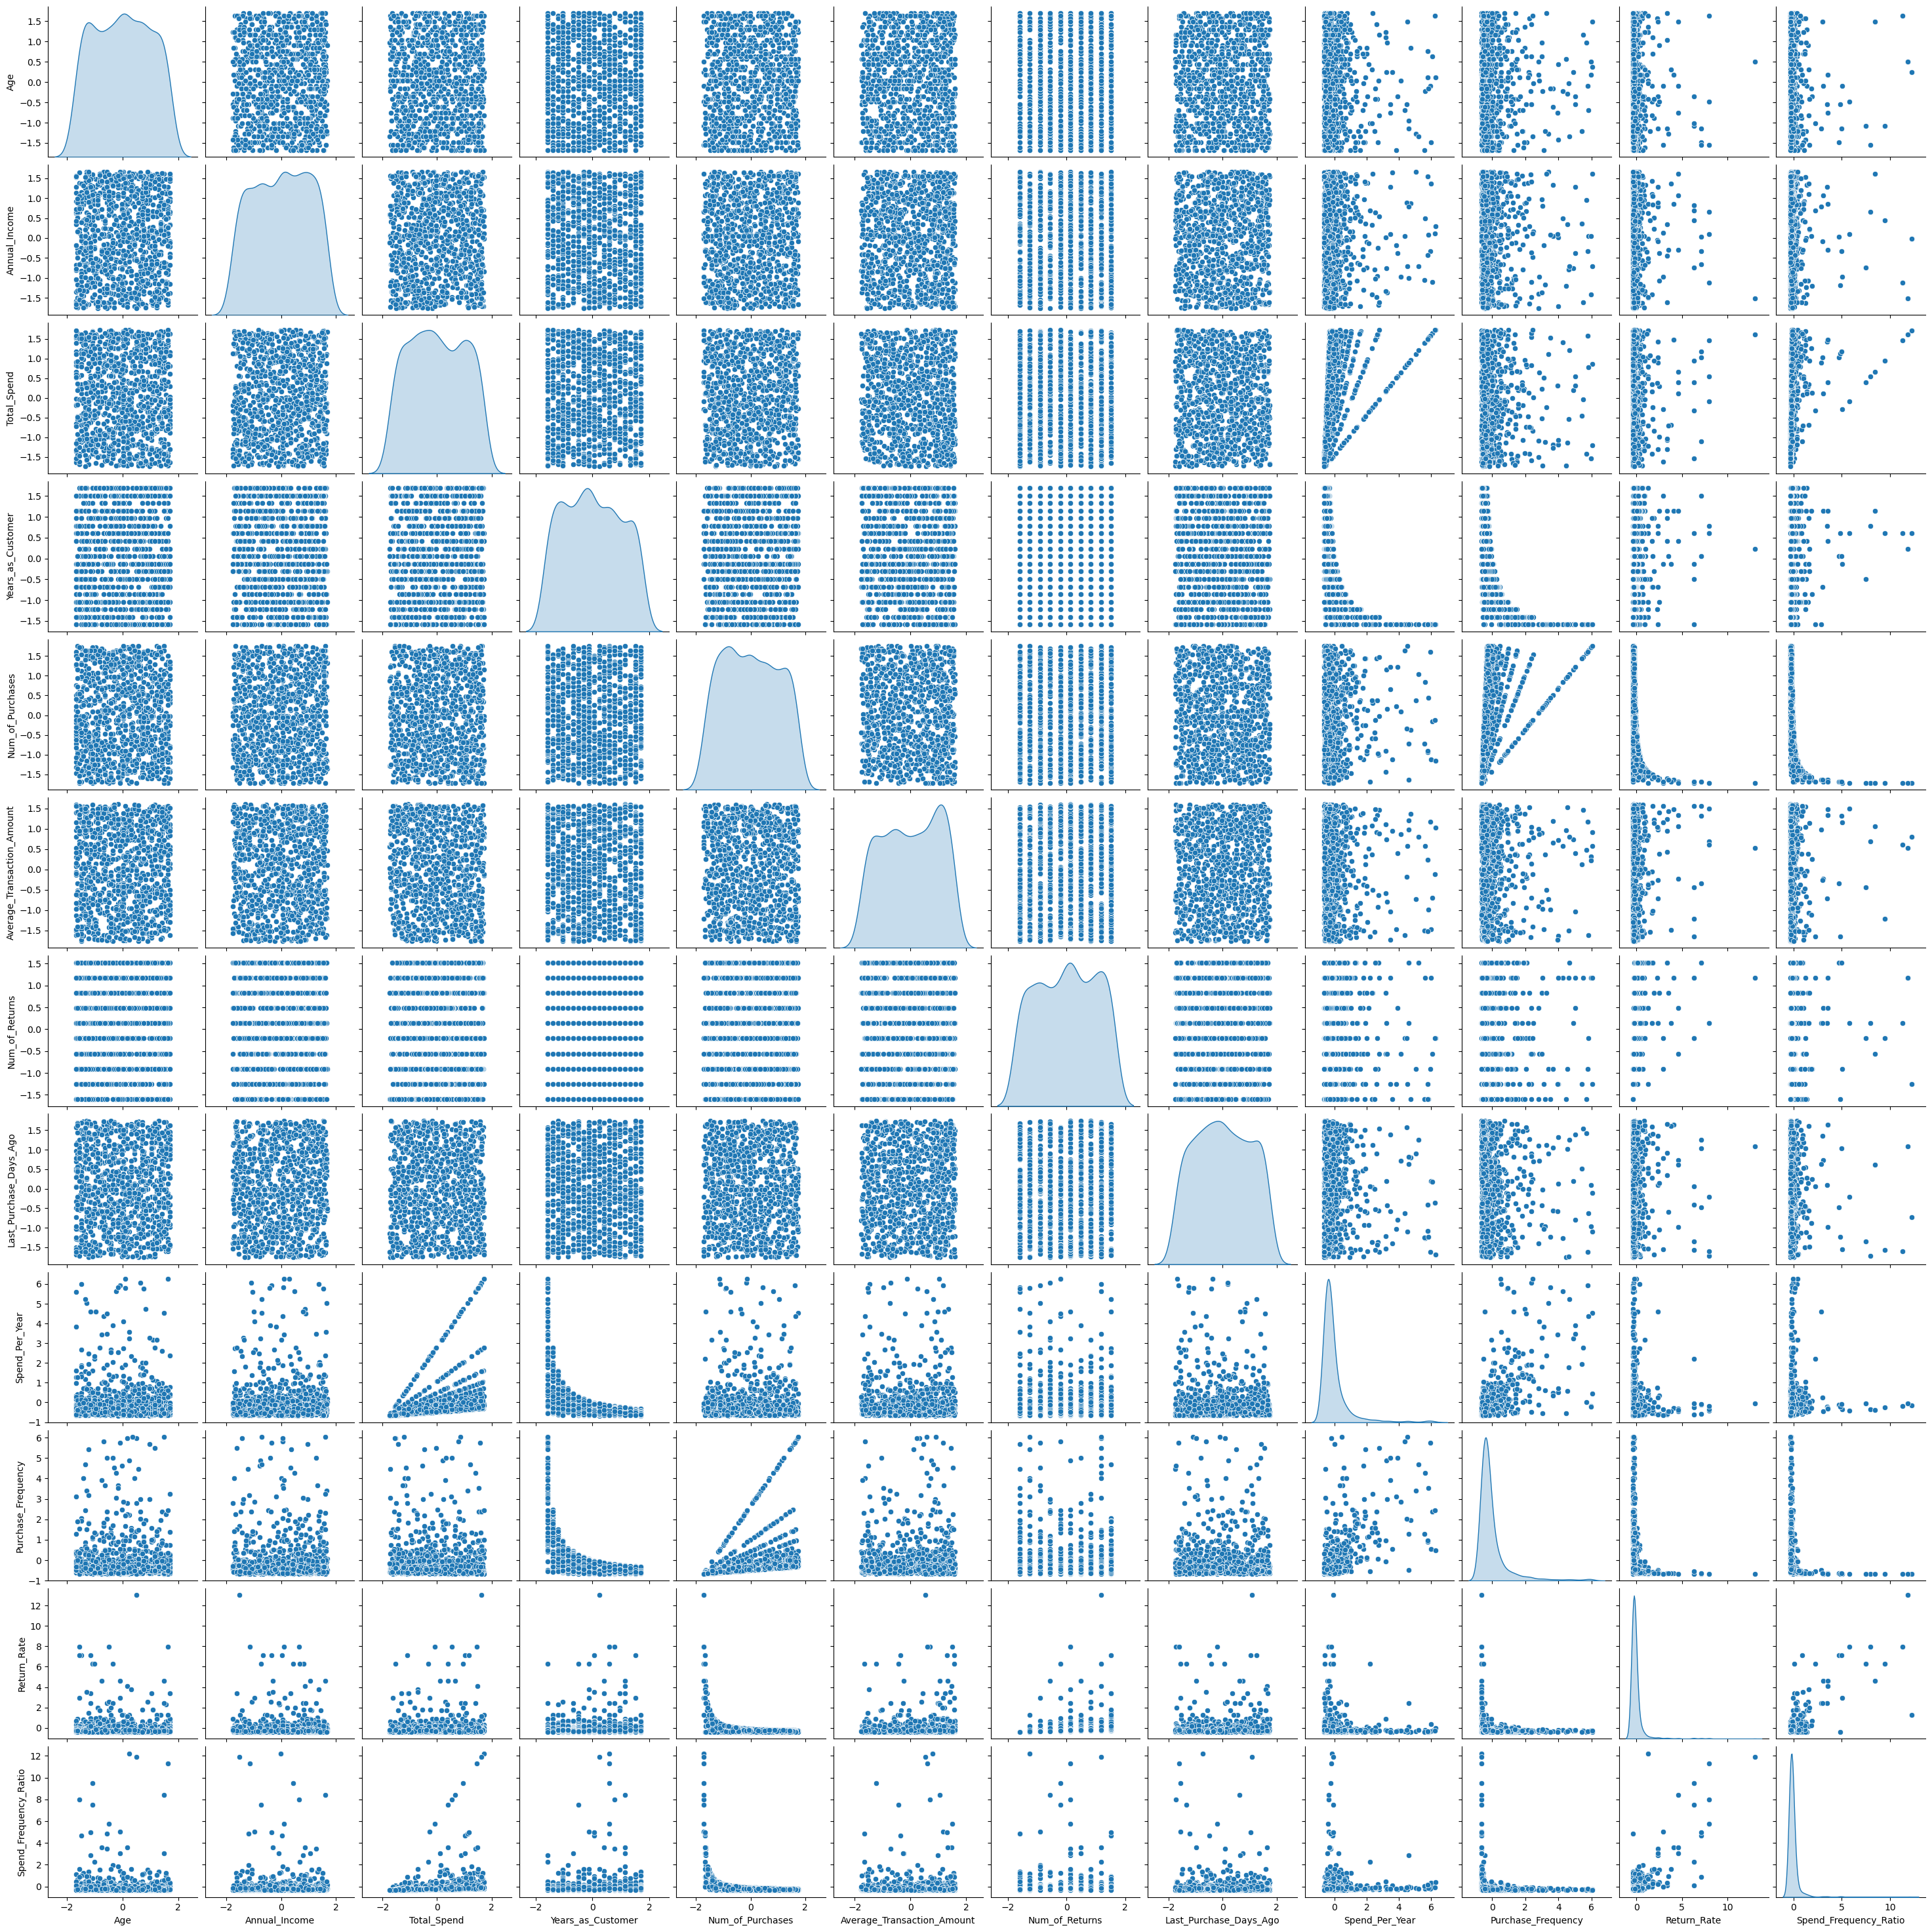

In [25]:
# Let's look at a pairplot of the numeric columns to see if we can spot any patterns.
# First, let's suppress the FutureWarnings about use_inf_as_na being deprecated.
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import seaborn as sns
sns.pairplot(scaled_df, diag_kind='kde')
plt.show()

Looking at the pairplot, there are no strong correlations between the numeric columns. This is good, as it means we can use all of them in our analysis. It also means that we can eliminate clustering algorithms that work well with obvious clusters. This means that we will need to explore several specific clustering algorithms to see which works best, but once we find one that works well, we can be confident that it's the best choice for all future clustering we'll need to do on this dataset. 

Let's look at:
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Hierarchical Aggolmerative Clustering (HAC)
- Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)
- Mean Shift
- Gaussian Mixture Models (GMM)

#### Determining the Most Valuable Customers

We have `Total_Spend`, which is simply historical CLV. We could simply say that the top 20% of customers by CLV are our most valuable customers and leave it at that. Let's perform some clustering to see whether this assumption holds up. 

<Axes: title={'center': 'Annual Income vs. Total Spend'}, xlabel='Annual_Income', ylabel='Total_Spend'>

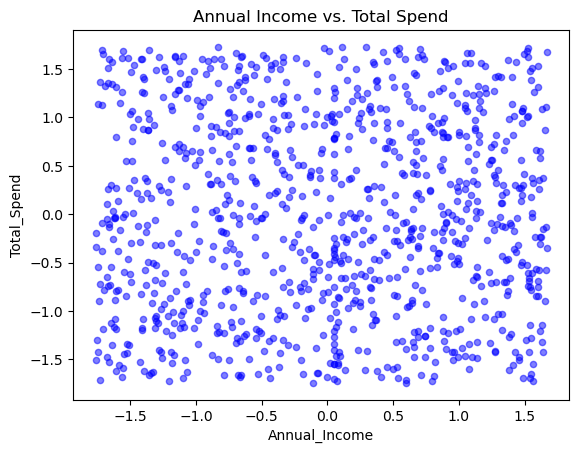

In [26]:
# The customers with the highest annual income and total spend are likely to be our most valuable customers, so let's learn more about them.
scaled_df.plot(kind="scatter", x="Annual_Income", y="Total_Spend", alpha=0.5, color="blue", title="Annual Income vs. Total Spend")

In [27]:
# Let's split the dataset into an X to simplify the clustering process.
X = pd.concat([scaled_df["Annual_Income"], scaled_df["Total_Spend"]], axis=1)

In [28]:
# Let's build a helper function to tune the hyperparameters of each model.
# Adapted from a hyperparameter tuning function in the book "Effective XGBoost", by Matt Harrison.
from sklearn.cluster import DBSCAN, HDBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from itertools import product

# Function to perform a grid search over DBSCAN parameters
def clustering_grid_search(X, algorithm, param_grid):
    # Initialize the best scores and parameters for each metric
    best_dbscore = np.inf  # Lower Davies-Bouldin Score is better
    best_silscore = -1    # Higher Silhouette Score is better
    best_chscore = -1     # Higher Calinski-Harabasz Score is better
    best_dbparams = best_silparams = best_chparams = None

    # Generate all combinations of parameters
    param_combinations = list(
        product(*(param_grid[name] for name in param_grid)))

    # Iterate over all combinations of parameters
    for params in param_combinations:
        # Unpack parameters
        kwargs = dict(zip(param_grid.keys(), params))

        # Initialize the clustering model based on the input algorithm
        if algorithm == 'DBSCAN':
            model = DBSCAN(**kwargs)
        elif algorithm == 'HAC':
            model = AgglomerativeClustering(**kwargs)
        elif algorithm == 'HDBSCAN':
            model = HDBSCAN(**kwargs)
        elif algorithm == 'MeanShift':
            model = MeanShift(**kwargs)
        elif algorithm == 'GMM':
            model = GaussianMixture(**kwargs)
        else:
            raise ValueError("Unsupported algorithm specified")

        # Fit the model and predict labels
        labels = model.fit_predict(X)

        # Calculate scores only if more than one cluster and not all noise
        if len(set(labels)) > 1 and not (len(set(labels)) == 2 and -1 in labels):
            try:
                silscore = silhouette_score(X, labels)
                if silscore > best_silscore:
                    best_silscore = silscore
                    best_silparams = kwargs
            except ValueError:
                pass  # Silhouette score cannot be calculated for a single cluster

            try:
                dbscore = davies_bouldin_score(X, labels)
                if dbscore < best_dbscore:
                    best_dbscore = dbscore
                    best_dbparams = kwargs
            except ValueError:
                pass

            try:
                chscore = calinski_harabasz_score(X, labels)
                if chscore > best_chscore:
                    best_chscore = chscore
                    best_chparams = kwargs
            except ValueError:
                pass

    print(
        f"Best params for Davies-Bouldin Score in {algorithm}: {best_dbparams}")
    print(f"Best Davies-Bouldin Score: {np.round(best_dbscore, 3)}")
    print(f"Best params for Silhouette Score in {algorithm}: {best_silparams}")
    print(f"Best Silhouette Score: {np.round(best_silscore, 3)}")
    print(
        f"Best params for Calinski-Harabasz Score in {algorithm}: {best_chparams}")
    print(f"Best Calinski-Harabasz Score: {np.round(best_chscore, 3)}")
    

In [29]:
param_grid_dbscan = {
    'eps': [0.170, 0.172, 0.1723, 0.1725, 0.175, 0.177, 0.185],
    'min_samples': [4, 5, 6, 7, 8, 9]
}
clustering_grid_search(X, 'DBSCAN', param_grid_dbscan)

Best params for Davies-Bouldin Score in DBSCAN: {'eps': 0.175, 'min_samples': 8}
Best Davies-Bouldin Score: 1.315
Best params for Silhouette Score in DBSCAN: {'eps': 0.1725, 'min_samples': 9}
Best Silhouette Score: 0.089
Best params for Calinski-Harabasz Score in DBSCAN: {'eps': 0.17, 'min_samples': 8}
Best Calinski-Harabasz Score: 190.254


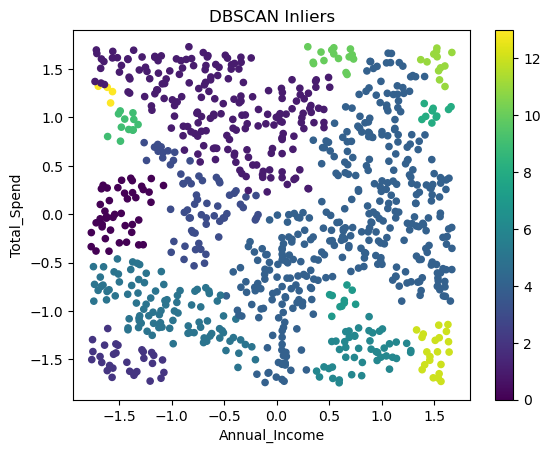

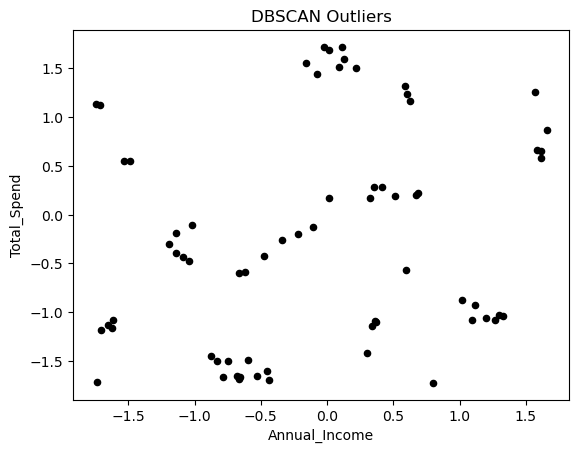

Davies-Bouldin_score: 1.3152697035452916
Silhouette_score: -0.0629914878465101
Calinski-Harabasz_score: 156.51218094368323


In [30]:
# Let's run DBSCAN based on our hyperparameter tuning results above.
dbscan = DBSCAN(eps=0.175, min_samples=8)
dbscan.fit(X)

# Get inliers and their cluster labels
X_inlier = X[dbscan.labels_ != -1]
y_inlier = dbscan.labels_[dbscan.labels_ != -1]

# Get outliers
X_outlier = X[dbscan.labels_ == -1]
X_inlier.plot.scatter(x="Annual_Income", y="Total_Spend", c=y_inlier, cmap='viridis', title="DBSCAN Inliers")
X_outlier.plot.scatter(x="Annual_Income", y="Total_Spend", color='k', title="DBSCAN Outliers")

# Visualize the clusters
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, dbscan.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, dbscan.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, dbscan.labels_)}")

In [31]:
# Let's see what the hyperparameter tuning function suggests for HAC.
param_grid_hac = {
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['ward', 'complete', 'average', 'single']
}
clustering_grid_search(X, 'HAC', param_grid_hac)

Best params for Davies-Bouldin Score in HAC: {'n_clusters': 3, 'linkage': 'single'}
Best Davies-Bouldin Score: 0.793
Best params for Silhouette Score in HAC: {'n_clusters': 6, 'linkage': 'average'}
Best Silhouette Score: 0.351
Best params for Calinski-Harabasz Score in HAC: {'n_clusters': 6, 'linkage': 'average'}
Best Calinski-Harabasz Score: 838.831


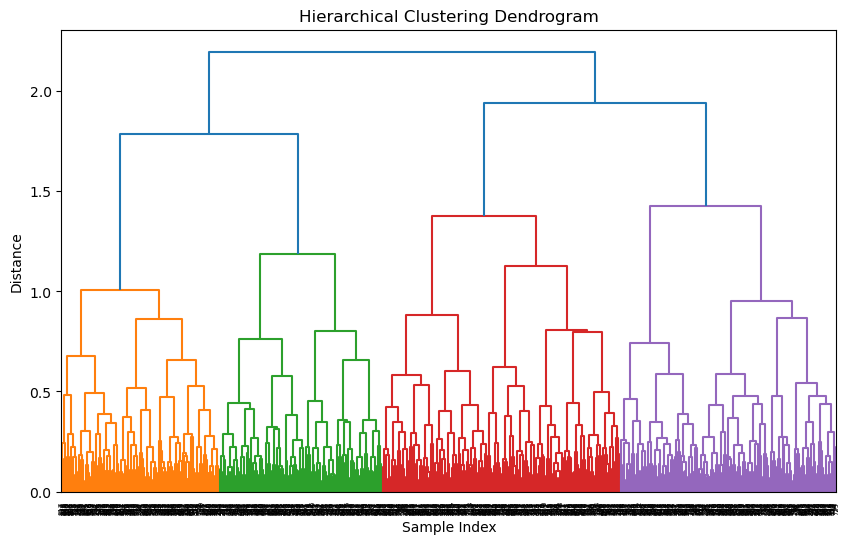

In [32]:
# Let's move on to HAC.
# Let's visualize a dendrogram of the data to get an idea of how many clusters we should aim for with HAC.
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'average')

plt.figure(figsize=(10, 6))
hierarchy.dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

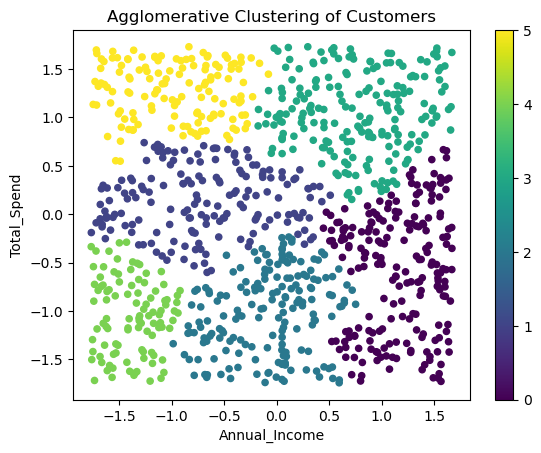

Davies-Bouldin_score: 0.8715893344421567
Silhouette_score: 0.35109120898408663
Calinski-Harabasz_score: 838.831297069886


In [33]:
# Using the Davies-Bouldin Score as the primary metric resulted in one cluster. The Silhouette Score and Calinski-Harabasz Score suggest six clusters.
hac = AgglomerativeClustering(n_clusters=6, linkage="average")
hac.fit(X)

X.plot.scatter(x="Annual_Income", y="Total_Spend", c=hac.labels_, cmap='viridis', title="Agglomerative Clustering of Customers")

# Visualize the clusters
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, hac.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, hac.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, hac.labels_)}")

In [34]:
# Let's move on to HDBSCAN.
param_grid_hdbscan = {
    'min_cluster_size': [2, 3, 4, 5, 6, 12, 24, 48, 72, 100], 
    'cluster_selection_epsilon': [0, 0.15, 0.2, 0.25, 0.5, 3, 5, 7]}
clustering_grid_search(X, 'HDBSCAN', param_grid_hdbscan)

In [ ]:
# Let's try HDBSCAN next.
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=0.2)
hdb.fit(X)

# Get inliers and their cluster labels
X_inlier = X[hdb.labels_ != -1]
y_inlier = hdb.labels_[hdb.labels_ != -1]

# Get outliers
X_outlier = X[hdb.labels_ == -1]
X_inlier.plot.scatter(x="Annual_Income", y="Total_Spend",
                      c=y_inlier, cmap='viridis', title="HDBSCAN Inliers")
X_outlier.plot.scatter(x="Annual_Income", y="Total_Spend",
                       color='k', title="HDBSCAN Outliers")
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(X, hdb.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, hdb.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(X, hdb.labels_)}")

In [ ]:
# Let's try mean shift next. Before we try hyperparameter tuning, let's estimate the bandwidth.
bandwidth = estimate_bandwidth(X, quantile=0.2)
print(bandwidth)

In [ ]:

param_grid_meanshift = {'bandwidth': [1, bandwidth, 1.05, 1.06, 1.07, 1.1]}
clustering_grid_search(X, 'MeanShift', param_grid_meanshift)

In [ ]:
ms = MeanShift(bandwidth=1.07)
ms.fit(X)
labels = ms.labels_

X.plot.scatter(x="Annual_Income", y="Total_Spend", c=ms.labels_,
               cmap='viridis', title="Mean Shift Clustering of Customers")

# Find the cluster with the highest total spend
X_with_labels = X.copy()
X_with_labels['Cluster'] = ms.labels_
max_spend_index = X_with_labels['Total_Spend'].idxmax()
cluster_with_highest_spend = X_with_labels.loc[max_spend_index, 'Cluster']

print(f"Davies-Bouldin_score: {davies_bouldin_score(X, ms.labels_)}")
print(f"Silhouette_score: {silhouette_score(X, ms.labels_)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(X, ms.labels_)}")

In [ ]:
# Finally, let's try GMM.
param_grid_gmm = {
    'n_components': [5, 6, 7, 8],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(X, 'GMM', param_grid_gmm)

In [ ]:
import plotly.graph_objects as go
gmm = GaussianMixture(n_components=8, covariance_type='spherical',
                        init_params='kmeans', random_state=42)
gmm.fit(X)
mvc_labels = gmm.fit_predict(X)

X.plot(kind="scatter", x="Annual_Income", y="Total_Spend", c=mvc_labels, cmap='viridis', title="GMM Clustering of Customers")

X_gmm = X.copy()
X_gmm["Cluster"] = labels
max_spend_index = X_gmm['Total_Spend'].idxmax()

print(f"Davies-Bouldin_score: {davies_bouldin_score(X, mvc_labels)}")
print(f"Silhouette_score: {silhouette_score(X, mvc_labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(X, mvc_labels)}")

In [ ]:
import plotly.graph_objects as go

# Create a helper function to visualize 2D plots in Plotly
def plot_2d(df, x_axis, y_axis, labels, title):
    fig = go.Figure(data=go.Scatter(
    x=df[x_axis],
    y=df[y_axis],
    mode='markers',  # Define the plot type, 'markers' for scatter plot
    marker=dict(
        color=labels,  # Set marker colors based on labels
        colorscale='Viridis',  # Define the color scale
        showscale=True,  # Show color scale bar
    ),
    text=[f"Cluster: {label}" for label in labels],
    hoverinfo='text'
    ))

    # Update the layout of the plot
    fig.update_layout(
        title=title,
        xaxis_title=x_axis,
        yaxis_title=y_axis,
        autosize=False,  # Disable autosize to set custom width and height
        width=800,  # Set the width of the plot
        height=600,  # Set the height of the plot
        # Optionally, if you want to maintain a specific aspect ratio
        yaxis=dict(
            scaleanchor="x",
            scaleratio=1,
        ),
    )


    # Show the plot
    fig.show()

In [ ]:
(X_gmm["Cluster"]==4).sum()

In [ ]:
plot_2d(X, "Annual_Income", "Total_Spend", mvc_labels, "GMM Clustering of Customers")

The wisdom of the crowds says that customers with the highest CLV and annual income are our most valuable customers. Let's examine the cluster analysis to see whether that's the case. Because most of these clusters have varying sizes and densities, let's compare scores (prioritizing Davies-Bouldin) to determine the best clustering algorithm for this dataset and have a go-to algorithm in case we need to do more clustering on similar data within the top cluster.

| Algorithm | Davies-Bouldin Score | Silhouette Score | Calinski-Harabasz Score |
|-----------|----------------------|------------------|-------------------------|    
| DBSCAN    | 1.315                |  -0.063          | 156.512                 |
| HAC       | 0.872                |  0.351           | 838.831                 |
| HDBSCAN   | 0.836                |  0.025           | 002.588                 |
| Mean Shift| 0.861                |  0.372           | 756.000                 |
| GMM       | 0.784                |  0.357           | 925.808                 |

I wouldn't expect the Silhouette Score to be the best metric for this dataset, as the clusters are not well-defined. The Davies-Bouldin and Calinski-Harabasz Scores are the best metric for this dataset, as they're more robust to varying cluster sizes and densities. Not only does GMM have the best Davies-Bouldin and Calinski-Harabasz scores, making it a good benchmark for future subsets of this dataset, but it also has clusters that make intuitive sense.

In [ ]:
# Create a new DataFrame of the most valuable customers based on the GMM clustering
mvc_clv = df.loc[X_gmm["Cluster"] == 4]

In [ ]:
mvc_clv.head()

In [ ]:
mvc_clv.shape

In [ ]:
mvc_clv.describe(include="all")

In [ ]:
# Let's look at the Gender column in more detail.
mvc_clv["Gender"].value_counts()

We can look at the range between the 25th and 75th percentile of our most valuable customer. This range will give us a good idea of the values we should target in our marketing efforts.
- 30-55 years old with annual incomes ranging from $158-186k. 
- Annual incomes range from $158-186k per year.
- There is no predominant gender.
- They have been customers for 6-15 years and make between 3-8 yearly purchases.
- Their total spend ranges from $7552 to $9226.
- They spend between $114 and $368 per transaction.
- Their yearly spending ranges from $570 to just under $1500.

Based on this analysis, we can take the following actions:
- Develop marketing campaigns to appeal to the 30-55 age group, emphasizing product characteristics likely to appeal to this demographic, like quality, value, and reliability.
- Develop premium products and experiences, such as VIP promotional and in-store networking events, high-end product bundles, and exclusive product customization options.
- Implement concierge customer service for high-value customers, providing personalized recommendations, early access to new products, and dedicated support channels.
- Implement a loyalty program based on length of time as a customer and total spend, offering exclusive benefits and rewards to long-term, high-value customers.
- Introduce incentives for customers making more than 3-8 purchases per year to encourage more frequent interactions.

While our current dataset provides valuable insights, it has limitations. We need a more granular transaction database, which hinders our ability to explore market basket analysis for cross-selling and up-selling opportunities. To address this, I propose working with the data engineering team to create a long dataset based on individual items within transactions. This will complement the existing `purchases` table and allow for more detailed analysis. The data model could look like this:

| Customer_ID | Timestamp | Transaction_ID | Item_ID | Quantity | Discount_Pct | Total_Sale_Amt |
|-------------|-----------|----------------|---------|----------|--------------|----------------|
| 164         | 2022-01-01| h0fb468b       | 18      | 2        | 0.15         | 97.73          |
| 164         | 2022-01-01| h0fb468b       | 5       | 1        | 0.00         | 51.82          |
| 52          | 2022-01-01| 0zk8djf4       | 12      | 1        | 0.05         | 25.91          |

And so on, with `Item_ID` as a foreign key to a separate `items` table containing columns such as `Item_Name`, `Item_Category`, `Item_Price`.

#### Determining Cross-Selling and Upselling Opportunities
We have a limited dataset for this analysis, but we can still explore potential cross-selling and up-selling opportunities based on the existing data. Let's turn back to our original dataset and review some possible approaches. The next half of the analysis will be an overview of identified clusters rather than a deep dive into each segment. At this point, it is enough to determine that a cluster exists. We can explore specific opportunities in a separate analysis.

In [ ]:
sns.pairplot(scaled_df, diag_kind='kde')
plt.show()

Most of the interesting, obvious trends are in the derived columns. 

The first obvious patterns are the diminishing returns in spend per year and purchase frequency as the number of years as a customer increases. We should attempt to address this with a loyalty program that rewards long-term customers for their continued patronage, as previously outlined. 

Second, the relationship between `Spend_Per_Year` and `Total_Spend` suggests at least three segments of customers who are consistent spenders with different "trajectories" of spend. We should look at the `Spend_Per_Year` and `Total_Spend` columns to identify these segments and tailor marketing campaigns to each segment's needs.

We should also look at the `Spend_Per_Year` and `Purchase Frequency` columns, which are the average amount each customer spent per year, and the number of purchases each customer made per year. This could indicate a segment of customers open to cross-selling (high `Purchase_Frequency`, low `Spend_Per_Year`) or engagement (low `Purchase_Frequency`, low `Spend_Per_Year`) opportunities.

Let's move up a dimension:
- Who spends the most? Total Spend vs. Average Transaction Amount vs. Spend Per Year


We can also look at:
- Total Spend vs. Years as a Customer (the most loyal customers: maybe introduce a loyalty program to slow the spend decline?)
- Spend Per Year vs. Purchase Frequency

In [ ]:
sns.scatterplot(data=scaled_df, x='Spend_Per_Year', y='Purchase_Frequency', hue='Total_Spend',
                palette='viridis', alpha=0.5).set(title="Spend per Year vs. Purchase Frequency vs. Total Spend")

In [ ]:
# Let's make another helper function, this time for 3D plots in Plotly.
def plot_3d(df, x_axis, y_axis, z_axis, labels, title, color=None):
    fig = go.Figure(data=[go.Scatter3d(
        x=df[x_axis],
        y=df[y_axis],
        z=df[z_axis],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
            color=df[color],
            colorbar=dict(title=color)
        )
    )])


    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=x_axis,
            yaxis_title=y_axis,
            zaxis_title=z_axis
        ),
        autosize=False,
        width=1000,
        height=800
    )

    fig.show()

In [ ]:
plot_3d(scaled_df, "Spend_Per_Year", "Purchase_Frequency", "Total_Spend", "Years_as_Customer",
        "Total Spend vs. Average Transaction Amount vs. Spend Per Year", color="Years_as_Customer")

It looks like the 3D scatterplot confirms the trend suggested on the 2D scatterplot: the biggest spenders tend to buy less frequently but on more expensive items, while the most frequent buyers tend to spend less per transaction. We can upsell to the former group by recommending higher-end alternatives to what they're already buying, offer exclusive customizations and add-ons, or provide premium bundles of high-value items. We can cross-sell to the latter group by recommending complementary products, implementing frequent-buyer offers, and implementing a reward system that incentivizes more frequent purchases.

The striations in the spend per year vs. total spend are interesting, but I'm not sure there's any "there" there. `Spend_Per_Year` is `Total_Spend` divided by `Years_as_Customer`: it's only natural that patterns would emerge when comparing a derived quantity to its base quantities.

Let's look at the `Average_Transaction_Amount` vs `Total_Spend`. 

In [ ]:
# Total Spend vs. Purchase Frequency vs. Number of Purchases
sns.scatterplot(data=scaled_df, x='Average_Transaction_Amount', y='Total_Spend',
                alpha=0.5).set(title="Average Transaction Amount vs. Total Spend")

In [ ]:
ata_ts = pd.concat([scaled_df["Average_Transaction_Amount"], scaled_df["Total_Spend"]], axis=1)
ata_ts.head()

In [ ]:
# HAC and GMM worked very well in the past. Let's try them again.
param_grid_hac = {
    'n_clusters': np.arange(1,10,1).tolist(),
    'linkage': ['ward', 'complete', 'average', 'single']
}
clustering_grid_search(ata_ts, 'HAC', param_grid_hac)

In [ ]:
# Optimizing for Davis-Bouldin created one cluster; Calinksi-Harabasz suggests four clusters.
hac = AgglomerativeClustering(n_clusters=4, linkage="complete")
hac.fit(ata_ts)

ata_ts.plot.scatter(x="Average_Transaction_Amount", y="Total_Spend", c=hac.labels_,
               cmap='viridis', title="Agglomerative Clustering of Customers")

# Visualize the clusters
plt.show()
print(f"Davies-Bouldin_score: {davies_bouldin_score(ata_ts, hac.labels_)}")
print(f"Silhouette_score: {silhouette_score(ata_ts, hac.labels_)}")
print(f"Calinski-Harabasz_score: {calinski_harabasz_score(ata_ts, hac.labels_)}")

In [ ]:
param_grid_gmm = {
    'n_components': np.arange(2, 10, 1).tolist(),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(ata_ts, 'GMM', param_grid_gmm)

In [ ]:
gmm = GaussianMixture(n_components=9, covariance_type='tied',
                        init_params='kmeans', random_state=42)
gmm.fit(ata_ts)
labels = gmm.fit_predict(ata_ts)
ata_ts_labels = gmm.fit_predict(ata_ts)

plot_2d(ata_ts, "Average_Transaction_Amount", "Total_Spend", ata_ts_labels, "GMM, Average Transaction Amount vs. Total Spend")

print(f"Davies-Bouldin_score: {davies_bouldin_score(ata_ts, labels)}")
print(f"Silhouette_score: {silhouette_score(ata_ts, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(ata_ts, labels)}")

GMM looks to be a more accurate model by the numbers. Clusters three and four represents customers with high total spend but low- to moderate average transaction amounts. This is a prime segment for upselling, as they are already spending a lot but could potentially spend more per transaction. We could offer them premium products, exclusive deals, or personalized recommendations to increase their average transaction amount.

Let's look at `Num_of_Purchases` vs. `Total_Spend`. Any segments with a high number of purchases but low total spend could be targeted for cross-selling opportunities. We could recommend complementary products, offer discounts on bundled items, or introduce loyalty programs to encourage repeat purchases.

In [ ]:
sns.scatterplot(data=scaled_df, x='Num_of_Purchases', y='Total_Spend',
                alpha=0.5).set(title="Number of Purchases vs. Total Spend")

In [ ]:
np_ts = pd.concat([scaled_df["Num_of_Purchases"], scaled_df["Total_Spend"]], axis=1)

In [ ]:
# Let's jump right to GMM
param_grid_gmm = {
    'n_components': np.arange(2, 10, 1).tolist(),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(np_ts, 'GMM', param_grid_gmm)

In [ ]:
# Let's optimize for Calinski-Harabasz score.
gmm = GaussianMixture(n_components=9, covariance_type='spherical',
                      init_params='kmeans', random_state=42)
gmm.fit(np_ts)
np_ts_labels = gmm.fit_predict(np_ts)

plot_2d(np_ts, "Num_of_Purchases", "Total_Spend", np_ts_labels, "GMM, Number of Purchases vs. Total Spend")

print(f"Davies-Bouldin_score: {davies_bouldin_score(np_ts, labels)}")
print(f"Silhouette_score: {silhouette_score(np_ts, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(np_ts, labels)}")

Clusters six and eight represent are the segment we can target for cross-selling. They have a high number of purchases but low total spend, indicating that they might be interested in additional products or services. We could offer them discounts on bundled items, recommend complementary products, or introduce a loyalty program to encourage repeat purchases.

Let's look at long-term customers and total spend. The longer-term, high-spend customers would be prime candidates for cross-selling and upselling. 

In [ ]:
yc_ts = pd.concat([scaled_df["Years_as_Customer"], scaled_df["Total_Spend"]], axis=1)
yc_ts.head()

In [ ]:
# Let's jump right to GMM
param_grid_gmm = {
    'n_components': np.arange(2, 10, 1).tolist(),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(yc_ts, 'GMM', param_grid_gmm)

In [ ]:
# Let's optimize for Calinski-Harabasz score.
gmm = GaussianMixture(n_components=4, covariance_type='spherical',
                      init_params='k-means++', random_state=42)
gmm.fit(yc_ts)
yc_ts_labels = gmm.fit_predict(yc_ts)

plot_2d(yc_ts, "Years_as_Customer", "Total_Spend", yc_ts_labels, "GMM, Years as Customer vs. Total Spend")

print(f"Davies-Bouldin_score: {davies_bouldin_score(yc_ts, yc_ts_labels)}")
print(f"Silhouette_score: {silhouette_score(yc_ts, yc_ts_labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(yc_ts, yc_ts_labels)}")

Cluster one represents the loyal, long-term customers we would like to retain. We could offer them exclusive or early access to new products and services, loyalty rewards, or personalized recommendations based on their purchase history.

Let's look at engagement: `Last_Purchase_Days_Ago` vs. `Num_of_Purchases`.

In [ ]:
lpda_np = pd.concat([scaled_df["Last_Purchase_Days_Ago"], scaled_df["Num_of_Purchases"]], axis=1)
lpda_np.head()

In [ ]:
# Let's jump right to GMM
param_grid_gmm = {
    'n_components': np.arange(2, 10, 1).tolist(),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(lpda_np, 'GMM', param_grid_gmm)

In [ ]:
# Let's optimize for Calinski-Harabasz score.
gmm = GaussianMixture(n_components=9, covariance_type='tied',
                      init_params='kmeans', random_state=42)
gmm.fit(lpda_np)
lpda_np_labels = gmm.fit_predict(lpda_np)

plot_2d(lpda_np, "Last_Purchase_Days_Ago", "Num_of_Purchases", lpda_np_labels, "GMM, Last Purchase Days Ago vs. Number of Purchases")

print(f"Davies-Bouldin_score: {davies_bouldin_score(lpda_np, labels)}")
print(f"Silhouette_score: {silhouette_score(lpda_np, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(lpda_np, labels)}")

Cluster six represents a highly-engaged segment: customers who purchased very recently and have a high number of purchases. We can target these customers with time-sensitive offers on complementary products or upgrades.

Finally, let's look at `Average_Transaction_Amount` vs. `Num_of_Returns`. We want to find a segment of high spenders with high return rates: they are a segment that could benefit from personalized consultations or premium customer service to ensure satisfaction with high-value purchases.

In [ ]:
ata_nr = pd.concat([scaled_df["Average_Transaction_Amount"], scaled_df["Num_of_Returns"]], axis=1)
ata_nr.head()

In [ ]:
# Let's jump right to GMM
param_grid_gmm = {
    'n_components': np.arange(2, 10, 1).tolist(),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'k-means++', 'random']
}
clustering_grid_search(ata_nr, 'GMM', param_grid_gmm)

In [ ]:
# Let's optimize for Calinski-Harabasz score.
gmm = GaussianMixture(n_components=9, covariance_type='tied',
                      init_params='kmeans', random_state=42)
gmm.fit(ata_nr)
ata_nr_labels = gmm.fit_predict(ata_nr)

plot_2d(ata_nr, "Average_Transaction_Amount", "Num_of_Returns", ata_nr_labels, "GMM, Average Transaction Amount vs. Number of Returns")

print(f"Davies-Bouldin_score: {davies_bouldin_score(ata_nr, labels)}")
print(f"Silhouette_score: {silhouette_score(ata_nr, labels)}")
print(f"Calinski_Harabasz_score: {calinski_harabasz_score(ata_nr, labels)}")

Cluster four, and cluster zero to a certain extent, represent clusters that could benefit from a premium customer service experience.

## Review and Iterate

To review, the 25th to 75th percentile of our most valuable customers revealed:
- They are 30-55 years old with annual incomes ranging from $158-186k. 
- Their annual incomes range from $158-186k per year.
- There is no predominant gender.
- They have been customers for 6-15 years and make between 3-8 yearly purchases.
- Their total spend ranges from $7552 to $9226.
- They spend between $114 and $368 per transaction.
- Their yearly spending ranges from $570 to just under $1500.

Based on this analysis, actionable strategies include:
- Develop marketing campaigns to appeal to the 30-55 age group, emphasizing product characteristics likely to appeal to this demographic, like quality, value, and reliability.
- Develop premium products and experiences, such as VIP promotional and in-store networking events, high-end product bundles, and exclusive product customization options.
- Implement concierge customer service for high-value customers, providing personalized recommendations, early access to new products, and dedicated support channels.
- Implement a loyalty program based on length of time as a customer and total spend, offering exclusive benefits and rewards to long-term, high-value customers.
- Introduce incentives for customers making more than 3-8 purchases per year to encourage more frequent interactions.

We can leverage these strategies to boost engagement and spend among other segments identified in the general population. Looking at our customer base more broadly, we identified seven scenarios with one or more clusters that are prime targets for cross-selling and upselling. Depending on the business' and marketing department's priorities, we could leverage many of the strategies above to engage with any number of these segments. I recommend a phased approach to implementation, starting with pilot programs in high-performing regions to gauge effectiveness and adjust tactics as needed. Continuous data monitoring and regular updates to the strategy will be crucial to adapt to changing customer preferences and market conditions.

This project reinforced my analytical and strategic planning skills and allowed me to dive deeper into more advanced clustering algorithms. Moving forward, I am particularly interested in exploring advanced predictive analytics to refine customer segmentation further and enhance personalization in marketing efforts.